# Housing Price

## Import modules


In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [184]:
# configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
sns.set_theme(style="darkgrid")

plt.rcParams.update({
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8 
})

RANDOM_STATE = 42
CSV_PATH = "data/Housing2.csv"
TARGET_COL = "price"

In [185]:
# load dataset 
df = pd.read_csv(CSV_PATH)

## Step 1: Data Overview and Initial Analysis

In [186]:
cols = list(df.columns)
new_cols = cols[1:] + [cols[0]]
df = df[new_cols]

print("Initial Dataset Shape:", df.shape)
display("Features Overview", df.head())

Initial Dataset Shape: (545, 13)


'Features Overview'

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,13300000
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,12250000
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,12250000
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,12215000
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished,11410000


## Step 2: Exploratory Data Analysis (EDA)

### Identify the types of features: Categorical vs Numerical

In [187]:
categorical_cols = df.select_dtypes(include='str').columns.to_list()
numerical_cols = df.select_dtypes(exclude='str').columns.to_list()
# print
print("Target column:",TARGET_COL)
print(f"Categorical Feature {categorical_cols}")
print(f"Numerical Feature: {numerical_cols}")

Target column: price
Categorical Feature ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
Numerical Feature: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']


### Handling missing values and show misisng data count

In [1]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing Values Features:\n", missing_values)

NameError: name 'df' is not defined

### Plot the distribution of the target variable (Price)

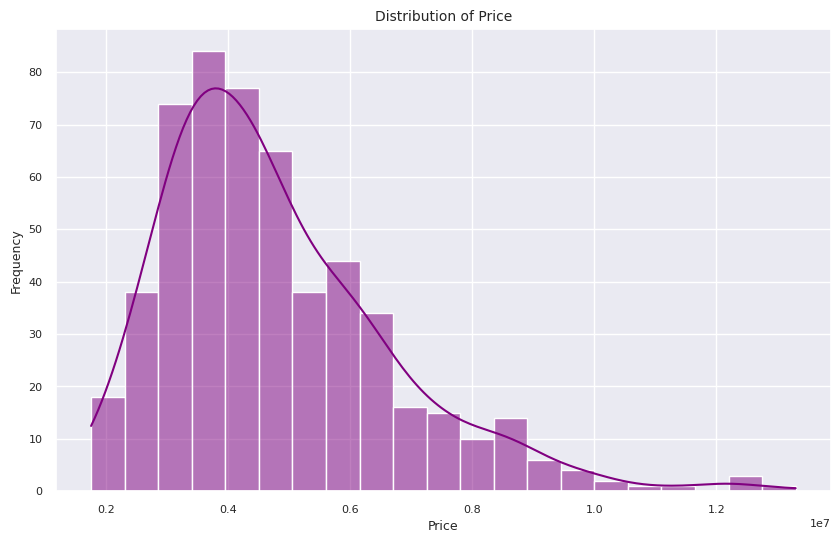

In [189]:
plt.figure(figsize=(10,6))
sns.histplot(x=df[TARGET_COL], kde=True, color='purple')
plt.title('Distribution of Price')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

## Correlation Heatmap for numerical features

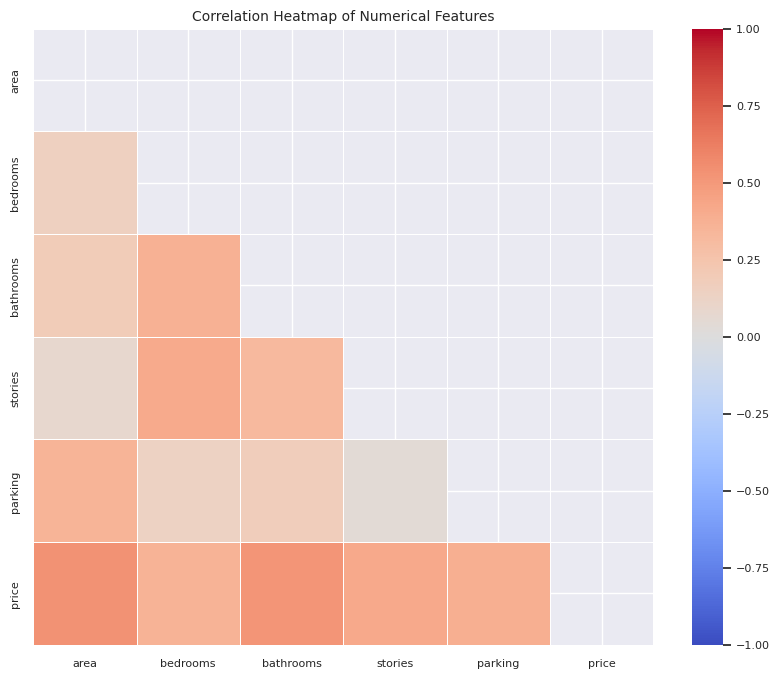

In [190]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df[numerical_cols].corr(), dtype=bool))
sns.heatmap(data=df[numerical_cols].corr(), mask=mask, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


## Step 3: Spliting the Data into Training and Testing Sets

In [191]:
# separate features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [192]:
X.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [193]:
y.head()

0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

## Step 4: Data Preprocessing and Feature Engineering

In [195]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

### Combine Transformers into a Preprocessor

In [196]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.to_list()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.to_list()

print("Numerical Features:",numerical_features)
print("Categorical Features:",categorical_features)

Numerical Features: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical Features: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [197]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Step 5: Create and Train Linear Regression Model Using Pipeline

In [198]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## Step 6: Model Predictions

In [199]:
y_tran_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

## Step 7: Evaluation Metrics for Training and Test Sets

In [200]:
def evaluate_model(y_true, y_pred, dataset_type="Training"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explain_var = explained_variance_score(y_true, y_pred)
    print(f"{dataset_type} Set Performace:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R^2): {r2:.2f}")
    print(f"Explained Variance Score: {explain_var:.2f}\n")
    
evaluate_model(y_train, y_tran_pred, dataset_type="Training")
evaluate_model(y_test, y_test_pred, dataset_type="Testing")

Training Set Performace:
Mean Squared Error (MSE): 968358188440.72
Mean Absolute Error (MAE): 719242.89
R-squared (R^2): 0.69
Explained Variance Score: 0.69

Testing Set Performace:
Mean Squared Error (MSE): 1754318687330.67
Mean Absolute Error (MAE): 970043.40
R-squared (R^2): 0.65
Explained Variance Score: 0.66



## Step 8: Residual Analysis

Residual Sum of Square (RSS)

In [201]:
rss_train = np.sum(np.square(y_train - y_tran_pred))
rss_test = np.sum(np.square(y_test - y_test_pred))
print("Residual Sum of Squares (RSS)")
print(f"Training Set RSS: {rss_train:.2f}")
print(f"Test Set RSS: {rss_test:.2f}\n")

Residual Sum of Squares (RSS)
Training Set RSS: 422204170160155.75
Test Set RSS: 191220736919042.84



### Residual Plot for test Set

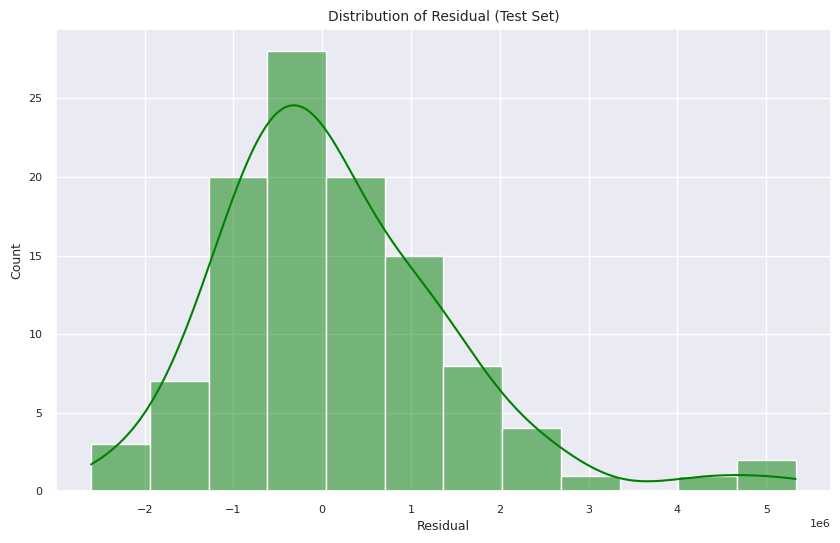

In [202]:
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(data=residuals, kde=True, color='green')
plt.title('Distribution of Residual (Test Set)')
plt.xlabel("Residual")
plt.show()

### Q-Q Plot for Residuals

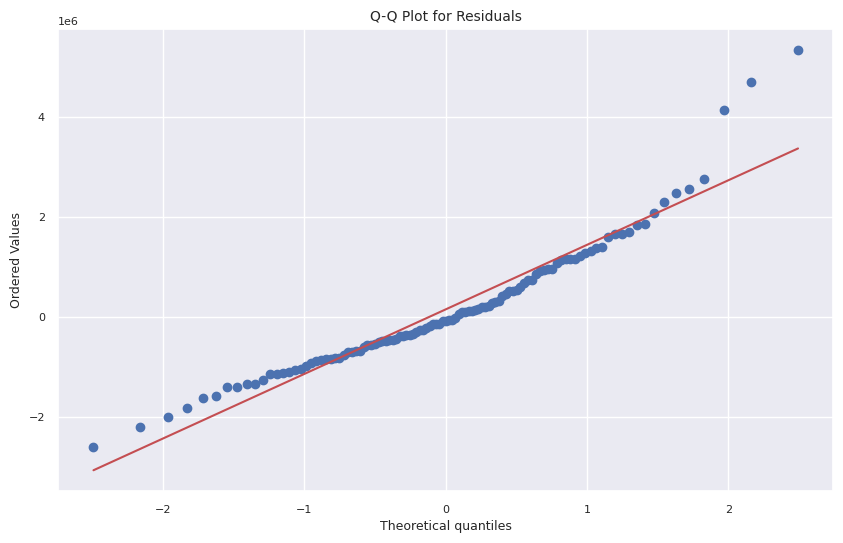

In [203]:
plt.figure(figsize=(10,6))
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot for Residuals')
plt.show()

### Criteria for Validating Residual Distribution with Numerical Analysis

In [204]:
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
residual_skew = stats.skew(residuals)
residual_kurtosis = stats.kurtosis(residuals)

print("Numerical Criteria for Validating Residuals:")
print(f"Mean of Residuals: {residual_mean:.2f} (Should be close to 0)")
print(f"Standar Deviation of Residuals: {residual_std:.2f} (Should be relatively samll)")
print(f"Skewness of Residuals: {residual_skew:.2f} (Should be close to 0 for normal distribution)")
print(f"Kurtosis of Residuals: {residual_kurtosis:.2f} (Should be close to 0 for normal distribution)")

Numerical Criteria for Validating Residuals:
Mean of Residuals: 146055.36 (Should be close to 0)
Standar Deviation of Residuals: 1316429.46 (Should be relatively samll)
Skewness of Residuals: 1.17 (Should be close to 0 for normal distribution)
Kurtosis of Residuals: 2.50 (Should be close to 0 for normal distribution)


## Step 9: Cross-Validation to Evaluate Model Performance

In [205]:
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cross_val_mse = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
cross_val_r2 = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
cross_val_mae = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')

print("Cross-Validation Results:")
print(f"Average Cross-Validation MSE: {-np.mean(cross_val_mse):.2f}")
print(f"Average Cross-Validation R-Squared: {np.mean(cross_val_r2):.2f}")
print(f"Average Cross-Validation MAE: {-np.mean(cross_val_mae):.2f}")


Cross-Validation Results:
Average Cross-Validation MSE: 1214842339413.01
Average Cross-Validation R-Squared: 0.61
Average Cross-Validation MAE: 807308.89


## Step 10: Hyperparameter Tuning with Ridge and Lasso Regression

### Ridge Regression Tuning

In [206]:
ridge_parms = {'model__alpha': [0.1, 1.0, 10.0, 10.0]}
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', Ridge())])

ridge_search = GridSearchCV(ridge_pipeline, ridge_parms, cv=5, scoring='neg_mean_squared_error')

ridge_search.fit(X_train, y_train)
print(f"Best Alpha for Ridge: {ridge_search.best_params_['model__alpha']}")
print(f"Best Ridge Model MSE: {-ridge_search.best_score_:.2f}")

Best Alpha for Ridge: 10.0
Best Ridge Model MSE: 1058017914145.57


### Lasso Regression Tuning

In [209]:
lasso_params = {'model__alpha':[0.001, 0.01, 0.1, 1.0]}
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model',Lasso())])
lasso_search = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X_train, y_train)

print(f"Best ALpha for Lasso: {lasso_search.best_params_['model__alpha']}")
print(f"Best Lasso Model MSE: {-lasso_search.best_score_:.2f}")

Best ALpha for Lasso: 1.0
Best Lasso Model MSE: 1062639771174.84
